# ===============================================
# Capstone Project
# ===============================================
# Author: Vishnu Prasad
# Description: This script demonstrates a well-structured Python project.
# It includes data processing, machine learning, and results visualization.


In [1]:
from google.colab import drive  # Import the Google Drive module
drive.mount('/content/drive')   # Mount Google Drive to access files


Mounted at /content/drive


In [2]:
!pip install tensorflow

In [3]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import os
import zipfile
import shutil
import random
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from PIL import Image

In [4]:

# Define the path to the ZIP file and extraction folder
zip_path = "/content/drive/MyDrive/Waste Segregation New.zip"
extract_folder = "/content/garbage_dataset"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Files extracted to:", extract_folder)


Files extracted to: /content/garbage_dataset


In [5]:
# Define Dataset Path
input_folder = "/content/garbage_dataset/Waste Segregation New/Waste- Segregation New"
train_dir = "/content/train_folder"
test_dir = "/content/test_folder"

In [6]:

# Create new directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Collect all image paths and labels
image_paths = []
labels = []

for class_name in os.listdir(input_folder):
    class_path = os.path.join(input_folder, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            image_paths.append(img_path)
            labels.append(class_name)

# Convert to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Split dataset (80% train, 20% test)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Function to copy images into respective directories
def copy_files(file_paths, labels, destination_folder):
    for img_path, label in zip(file_paths, labels):
        label_folder = os.path.join(destination_folder, label)
        os.makedirs(label_folder, exist_ok=True)
        shutil.copy(img_path, os.path.join(label_folder, os.path.basename(img_path)))

# Copy files into train and test folders
copy_files(train_paths, train_labels, train_dir)
copy_files(test_paths, test_labels, test_dir)

print("Data split completed. Train and test sets are ready.")

Data split completed. Train and test sets are ready.


In [7]:
# Define the target image size for model input
img_size = (150, 150)
# Define batch size for training and testing data
batch_size = 32

# Data Augmentation & Preprocessing

# Create a training data generator with data augmentation to improve generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values
    rotation_range=40,      # Rotate images up to 40 degrees
    width_shift_range=0.2,  # Shift width by up to 20%
    height_shift_range=0.2, # Shift height by up to 20%
    shear_range=0.2,        # Shear distortions
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Flip images horizontally
    brightness_range=[0.8, 1.2], # Adjust brightness randomly
    fill_mode='nearest'     # Fill missing pixels after transformations
)


# Load Data from Directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb'
)


# Display Class Labels
# Extract class names from the training generator
class_names = list(train_generator.class_indices.keys())
# Print the class labels for verification
print("Class Labels:", class_names)


Found 19892 images belonging to 12 classes.
Class Labels: ['biological', 'clothes', 'concrete', 'e-waste', 'explosive', 'glass', 'medical-waste', 'metal', 'paper', 'plastic', 'rubber', 'wood']


In [8]:
# Count images in each class
class_counts = {}
for class_name in os.listdir(train_dir):
    class_folder = os.path.join(train_dir, class_name)
    if os.path.isdir(class_folder):  # Ensure it's a directory
        num_images = len(os.listdir(class_folder))
        class_counts[class_name] = num_images

        # Print the count of images per class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

plastic: 1708 images
metal: 1620 images
concrete: 1678 images
glass: 1594 images
paper: 1612 images
biological: 1586 images
rubber: 1897 images
explosive: 1347 images
medical-waste: 1647 images
clothes: 1860 images
wood: 1622 images
e-waste: 1721 images


In [9]:

# Get class names
class_names = list(train_generator.class_indices.keys())
print("Class Labels:", class_names)

# Load the pre-trained VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze lower layers and fine-tune upper layers
for layer in base_model.layers[:15]:
    layer.trainable = False

# Create custom classification head
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(train_generator.num_classes, activation='softmax')(x)

Class Labels: ['biological', 'clothes', 'concrete', 'e-waste', 'explosive', 'glass', 'medical-waste', 'metal', 'paper', 'plastic', 'rubber', 'wood']
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model # Import Model
model = Model(inputs=base_model.input, outputs=output_layer) # Create the model

# Compile the model with Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Adjust learning rate if needed
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
# Enable loading of truncated images to avoid errors
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Function to Remove Corrupt Images

def remove_corrupt_images(directory):
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                try:
                    with Image.open(image_path) as img:
                        img.verify()  # Check if the image is corrupt
                except (IOError, OSError):
                    print(f"Removing corrupt image: {image_path}")
                    os.remove(image_path)

# Execute the Function for Train and Test Datasets
remove_corrupt_images("/content/train_folder")
remove_corrupt_images("/content/test_folder")

print("Corrupt images removed.")


Corrupt images removed.


In [12]:
# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, verbose=1)

# Train Model
history = model.fit(
    train_generator,
    epochs=15,  # Adjust as needed
    callbacks=[reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
278/622 ━━━━━━━━━━━━━━━━━━━━ 1:32 270ms/step - accuracy: 0.3786 - loss: 2.1293

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


622/622 ━━━━━━━━━━━━━━━━━━━━ 182s 277ms/step - accuracy: 0.4765 - loss: 1.7630 - learning_rate: 1.0000e-04
Epoch 2/15
622/622 ━━━━━━━━━━━━━━━━━━━━ 168s 271ms/step - accuracy: 0.7518 - loss: 0.7863 - learning_rate: 1.0000e-04
Epoch 3/15
622/622 ━━━━━━━━━━━━━━━━━━━━ 168s 269ms/step - accuracy: 0.8111 - loss: 0.5939 - learning_rate: 1.0000e-04
Epoch 4/15
622/622 ━━━━━━━━━━━━━━━━━━━━ 167s 269ms/step - accuracy: 0.8464 - loss: 0.4784 - learning_rate: 1.0000e-04
Epoch 5/15
622/622 ━━━━━━━━━━━━━━━━━━━━ 168s 269ms/step - accuracy: 0.8715 - loss: 0.4137 - learning_rate: 1.0000e-04
Epoch 6/15
622/622 ━━━━━━━━━━━━━━━━━━━━ 167s 269ms/step - accuracy: 0.8789 - loss: 0.3747 - learning_rate: 1.0000e-04
Epoch 7/15
622/622 ━━━━━━━━━━━━━━━━━━━━ 166s 267ms/step - accuracy: 0.8903 - loss: 0.3454 - learning_rate: 1.0000e-04
Epoch 8/15
622/622 ━━━━━━━━━━━━━━━━━━━━ 167s 268ms/step - accuracy: 0.9052 - loss: 0.2941 - learning_rate: 1.0000e-04
Epoch 9/15
622/622 ━━━━━━━━━━━━━━━━━━━━ 168s 270ms/step - accuracy:

In [13]:
# Function to preprocess images (convert non-RGB images to RGB)
def preprocess_image(image_path):
    img = Image.open(image_path)
    if img.mode != "RGB":
        img = img.convert("RGB")  # Convert to RGB
    return np.array(img) / 255.0  # Normalize

# Custom ImageDataGenerator to preprocess images
class CustomImageDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, **kwargs):
        generator = super().flow_from_directory(directory, **kwargs)

        def preprocess_batch():
            batch_x, batch_y = next(generator)
            batch_x = np.array([preprocess_image(img_path) for img_path in generator.filepaths])
            return batch_x, batch_y

        generator.__next__ = preprocess_batch
        return generator

# Create a test data generator
test_datagen = CustomImageDataGenerator(rescale=1./255)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

Found 4974 images belonging to 12 classes.


In [14]:
# Evaluate the Model on the Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.9498 - loss: 0.1851
Test Accuracy: 0.94


In [15]:
# Save and Load the Model
model.save("/content/drive/My Drive/models/trained_model_new.h5")
print("Model saved successfully in Google Drive!")


Model saved successfully in Google Drive!


In [16]:
# Load the trained deep learning model from the specified path
# Ensure the model file (.h5) exists in the given directory

model = load_model("/content/drive/My Drive/models/trained_model_new.h5")



In [17]:
# Print the summary of the loaded deep learning model

print(model.summary())



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 19,046,990 (72.66 MB)

 Trainable params: 11,410,188 (43.53 MB)

 Non-trainable params: 7,636,800 (29.13 MB)

 Optimizer params: 2 (12.00 B)

None


In [18]:
# Load and preprocess image for prediction
def preprocess_image(image_path, img_size=(150, 150)):
    img = image.load_img(image_path, target_size=img_size)  # Load and resize image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for model input
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Predict the class of an image
def predict_class(image_path, model, class_names):
    img_array = preprocess_image(image_path)  # Preprocess image
    prediction = model.predict(img_array)  # Get model prediction
    predicted_class = class_names[np.argmax(prediction)]  # Get class with highest probability
    confidence = np.max(prediction) * 100  # Get confidence percentage
    return predicted_class, confidence


In [20]:
import os

image_path = "/content/test_folder/clothes/clothes1015.jpg"  # Update this with an actual file

if os.path.isdir(image_path):
    print("❌ ERROR: This is a directory. Please provide an image file path.")
else:
    predicted_class, confidence = predict_class(image_path, model, class_names)
    print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: medical-waste, Confidence: 84.69


In [25]:
# Define the path of the image to be predicted
image_path = "/content/test_folder/clothes/clothes1127.jpg"  # Update with the actual image path

# Perform prediction using the trained model
predicted_class, confidence = predict_class(image_path, model, class_names)

# Display the prediction result
print(f"Predicted Class: {predicted_class} ({confidence:.2f}% confidence)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Class: clothes (99.41% confidence)


In [22]:

# Get true labels from test generator
y_true = test_generator.classes  # True class labels

# Get predicted probabilities
y_pred_probs = model.predict(test_generator)

# Convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step
Classification Report:

               precision    recall  f1-score   support

   biological       0.96      0.96      0.96       396
      clothes       0.97      0.98      0.97       465
     concrete       0.98      1.00      0.99       419
      e-waste       0.93      0.90      0.91       431
    explosive       0.99      0.95      0.97       337
        glass       0.94      0.83      0.88       399
medical-waste       0.89      0.94      0.91       412
        metal       0.81      0.95      0.88       405
        paper       0.94      0.93      0.93       403
      plastic       0.91      0.84      0.87       427
       rubber       0.98      0.99      0.99       474
         wood       0.98      0.98      0.98       406

     accuracy                           0.94      4974
    macro avg       0.94      0.94      0.94      4974
 weighted avg       0.94      0.94      0.94      4974



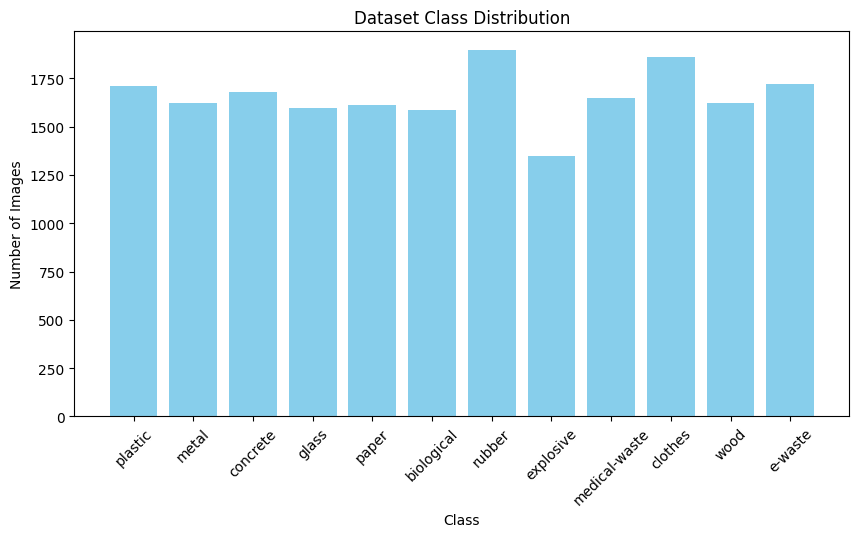

In [23]:
# Convert dictionary to lists for plotting
classes = list(class_counts.keys())
image_counts = list(class_counts.values())

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(classes, image_counts, color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Dataset Class Distribution")
plt.xticks(rotation=45)
plt.show()

In [24]:


# Compute mean and standard deviation of class counts
mean_count = np.mean(image_counts)
std_dev = np.std(image_counts)
cv = std_dev / mean_count  # Coefficient of Variation

print(f"Mean images per class: {mean_count:.2f}")
print(f"Standard deviation: {std_dev:.2f}")
print(f"Coefficient of Variation: {cv:.2f}")

# Interpretation
if cv > 0.5:
    print("⚠️ High class imbalance detected! Consider data augmentation or resampling.")
else:
    print("✅ Dataset is fairly balanced.")


Mean images per class: 1657.67
Standard deviation: 134.09
Coefficient of Variation: 0.08
✅ Dataset is fairly balanced.
